### Humble Beginings

It is time to take a good look at what we have. Given that, I plan to travel back and forth between EDA and feature engineering!

In [1]:
# for data munging
import pandas as pd
import numpy as np

# for dictionary execises
from collections import defaultdict

# for visualization and pitch drawing
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns

%matplotlib inline

In [2]:
# pandas setup as usual, just the way I like it!
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 120)
pd.set_option('display.precision', 3)

In [10]:
# read in the final dataset from 01
events = pd.read_csv("../../csv_files/AI_in_Soccer/events.csv", index_col=0)
events.head()

,id,matchId,gameweek,month,hour,teamHome,teamId,teamName,league,playerId,shortName,role,age,height,weight,foot,eventName,subEventName,matchPeriod,eventSec,x_start,y_start,x_end,y_end
0,177959171,2499719,1,8,18,Arsenal,1609,Arsenal,england,25413,A. Lacazette,FWD,26.599,175.0,73.0,right,Pass,Simple pass,1H,2.759,49,49,31,78
1,177959172,2499719,1,8,18,Arsenal,1609,Arsenal,england,370224,R. Holding,DEF,22.284,189.0,75.0,right,Pass,High pass,1H,4.947,31,78,51,75
2,177959173,2499719,1,8,18,Arsenal,1609,Arsenal,england,3319,M. \u00d6zil,MID,29.213,180.0,76.0,left,Pass,Head pass,1H,6.542,51,75,35,71
3,177959174,2499719,1,8,18,Arsenal,1609,Arsenal,england,120339,Mohamed Elneny,MID,25.476,180.0,70.0,right,Pass,Head pass,1H,8.143,35,71,41,95
4,177959175,2499719,1,8,18,Arsenal,1609,Arsenal,england,167145,Beller\u00edn,DEF,22.790,178.0,74.0,right,Pass,Simple pass,1H,10.302,41,95,72,88


### Missing Values and Handling Them

In [11]:
# rows and columns
print(f"The dataframe has total of {events.shape[0]} rows and {events.shape[1]} columns.")

The dataframe has total of 3071395 rows and 24 columns.


In [12]:
# let's check the nulls
print(events.isna().sum())

id                   0
matchId              0
gameweek             0
month                0
hour                 0
teamHome             0
teamId               0
teamName             0
league               0
playerId             0
shortName       226038
role            226038
age             226038
height          226038
weight          226038
foot            226647
eventName            0
subEventName      7821
matchPeriod          0
eventSec             0
x_start              0
y_start              0
x_end                0
y_end                0
dtype: int64


I see 226,038 player records are missing. I need the player `role` in modeling the second wing. Also, I need individual player coordinates data for the 1st wing. Therefore, I will exclude records with missing `role`.

In [13]:
events.dropna(subset=['role'], inplace=True)

In [14]:
events.shape

(2845357, 24)

In [15]:
# check again
print(events.isna().sum())

id                 0
matchId            0
gameweek           0
month              0
hour               0
teamHome           0
teamId             0
teamName           0
league             0
playerId           0
shortName          0
role               0
age                0
height             0
weight             0
foot             609
eventName          0
subEventName    7793
matchPeriod        0
eventSec           0
x_start            0
y_start            0
x_end              0
y_end              0
dtype: int64


I take a closer look at the records with mising `foot`.

In [16]:
print(events[events['foot'].isnull()]['shortName'].unique())
print(events[events['foot'].isnull()]['shortName'].nunique())

['D. McNeil' 'Mozo' 'Sergio Arribas' 'David Alba' 'Miguel'
 'Alberto L\\u00f3pez' 'Mujaid Sadick' 'Juan Cruz' 'S. Sanogo'
 'D. Alcibiade' 'N. Gandi' 'D. Lempereur' 'A. Sahibeddine']
13


There are only 13 players without preferred `foot` data. I will look them up manually and adjust accordingly.

In [17]:
# form 2 lists, one for left_foot one for right_foot
left_foot = ['D. McNeil', 'Alberto L\\u00f3pez', 'Juan Cruz', 'S. Sanogo', 'D. Lempereur']
right_foot = ['Mozo', 'Sergio Arribas', 'David Alba', 'Miguel', 'Mujaid Sadick', 'D. Alcibiade', 'N. Gandi', 'A. Sahibeddine']

In [18]:
# fill nan's with appropriate values
events.loc[events['shortName'].isin(pd.Series(['D. McNeil', 'Alberto L\\u00f3pez', 'Juan Cruz', 'S. Sanogo', 'D. Lempereur'])),'foot']='left'
events.loc[events['shortName'].isin(pd.Series(['Mozo', 'Sergio Arribas', 'David Alba', 'Miguel', 'Mujaid Sadick', 'D. Alcibiade', 
                                           'N. Gandi', 'A. Sahibeddine'])),'foot']='right'

# ignore this part, I wanted to test an alternative way
#events.[events['shortName'].isin(left_foot)].fillna("left", inplace=True)
#events[events['shortName'].isin(right_foot)].fillna("right", inplace=True)

And I take a look at rows with `subEventName`missing and see which event(s) they belong to.

In [19]:
print(events[events['subEventName'].isnull()]['eventName'].unique())
print(events[events['subEventName'].isnull()]['eventName'].nunique())

['Offside']
1


Just "offside"! Good! Lets check if we can use any existing `subEventName` we can replace NaN with first.

In [20]:
list(events.subEventName.unique())

['Simple pass',
 'High pass',
 'Head pass',
 'Air duel',
 'Ground loose ball duel',
 'Smart pass',
 'Launch',
 'Ground defending duel',
 'Ground attacking duel',
 'Foul',
 'Cross',
 'Shot',
 'Reflexes',
 'Touch',
 'Clearance',
 'Throw in',
 'Goal kick',
 'Free Kick',
 'Corner',
 'Goalkeeper leaving line',
 'Hand pass',
 'Acceleration',
 'Save attempt',
 nan,
 'Free kick cross',
 'Free kick shot',
 'Hand foul',
 'Violent Foul',
 'Protest',
 'Late card foul',
 'Out of game foul',
 'Penalty',
 'Time lost foul',
 'Simulation',
 'Whistle',
 'Ball out of the field']

None of these feel like anything close to offside. 

If you do not not what offside is plesae see [this](https://en.wikipedia.org/wiki/Offside_(association_football)). I want to set the value for the missing ones to "offside".

In [21]:
events.subEventName.fillna("Offside", inplace=True)

In [22]:
#final check for missing values
events.isna().sum()

id              0
matchId         0
gameweek        0
month           0
hour            0
teamHome        0
teamId          0
teamName        0
league          0
playerId        0
shortName       0
role            0
age             0
height          0
weight          0
foot            0
eventName       0
subEventName    0
matchPeriod     0
eventSec        0
x_start         0
y_start         0
x_end           0
y_end           0
dtype: int64

In [23]:
# quick check
events.head()

,id,matchId,gameweek,month,hour,teamHome,teamId,teamName,league,playerId,shortName,role,age,height,weight,foot,eventName,subEventName,matchPeriod,eventSec,x_start,y_start,x_end,y_end
0,177959171,2499719,1,8,18,Arsenal,1609,Arsenal,england,25413,A. Lacazette,FWD,26.599,175.0,73.0,right,Pass,Simple pass,1H,2.759,49,49,31,78
1,177959172,2499719,1,8,18,Arsenal,1609,Arsenal,england,370224,R. Holding,DEF,22.284,189.0,75.0,right,Pass,High pass,1H,4.947,31,78,51,75
2,177959173,2499719,1,8,18,Arsenal,1609,Arsenal,england,3319,M. \u00d6zil,MID,29.213,180.0,76.0,left,Pass,Head pass,1H,6.542,51,75,35,71
3,177959174,2499719,1,8,18,Arsenal,1609,Arsenal,england,120339,Mohamed Elneny,MID,25.476,180.0,70.0,right,Pass,Head pass,1H,8.143,35,71,41,95
4,177959175,2499719,1,8,18,Arsenal,1609,Arsenal,england,167145,Beller\u00edn,DEF,22.790,178.0,74.0,right,Pass,Simple pass,1H,10.302,41,95,72,88


Looks good!  Now, let's check the types and see what we can do about it.

### Data Types & Logic Checks

In [24]:
print(events.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2845357 entries, 0 to 3071394
Data columns (total 24 columns):
id              int64
matchId         int64
gameweek        int64
month           int64
hour            int64
teamHome        object
teamId          int64
teamName        object
league          object
playerId        int64
shortName       object
role            object
age             float64
height          float64
weight          float64
foot            object
eventName       object
subEventName    object
matchPeriod     object
eventSec        float64
x_start         int64
y_start         int64
x_end           int64
y_end           int64
dtypes: float64(4), int64(11), object(9)
memory usage: 542.7+ MB
None


Based on the info, here is what I can do:
- Quantify
    - `league` as `leagueNum`
    - `foot` as `footNum`
    - `matchPeriod` as `matchPeriodNum`
    - `role` as `roleNum`
- Round `age` to be integer
- Convert `x_start` and `y_start` to float
- Add `eventMin` as minute version of `eventSec` and round it up. I want to add a rounded version becuase the time measurements in football are done in minutes; goal in minute 34 means a goal happened somehwere between minutes 33:00 and 33:59.
    

I start by checking the unique values of each field. Then, I quantify via dictionaries.

In [25]:
# check the unique values of league, foot and matchPeriod
print("Unique values of league: ", events.league.unique())
print("Unique values of foot: ", events.foot.unique())
print("Unique values of matchPeriod: ", events.matchPeriod.unique())
print("Unique values of role: ", events.role.unique())

Unique values of league:  ['england' 'spain' 'italy' 'germany' 'france']
Unique values of foot:  ['right' 'left' 'both']
Unique values of matchPeriod:  ['1H' '2H']
Unique values of role:  ['FWD' 'DEF' 'MID' 'GKP']


In [26]:
# setup a dictionary for league, foot, and matchPeriod
league_dict = {"england": 1, "spain": 2, "italy": 3, "germany": 4, "france": 5}
foot_dict = {"right": 1, "left": 2, "both": 3}
matchPeriod_dict = {"1H": 1, "2H": 2}
role_dict = {"DEF": 1, "MID": 2, "FWD": 3, "GKP": 4}

In [27]:
# add quantified fields
events['leagueNum'] = events['league'].map(league_dict)
events['footNum'] = events['foot'].map(foot_dict)
events['matchPeriodNum'] = events['matchPeriod'].map(matchPeriod_dict)
events['roleNum'] = events['role'].map(role_dict)

# add and round minutes
events['eventMin'] = events['eventSec'].map(lambda x: x /60)
events['eventMinRounded'] = np.ceil(events.eventMin).astype(int)

There are 2 periods of 45 minutes (plus extra time) in a soccer match. Teams will change sides in 2nd period. Given that, I want to check if the coordinates are bi-directional or not. To check, I prefer to pick a goalkeeper in a match put in a scatter chart and observe the locations he met the ball during the match.

In [28]:
# pick a match and identify a goalkeeper
match = 2499719
print(events[(events.teamName == 'Leicester City') & \
             (events['matchId'] == 2499719) & \
             (events['role'] == 'GKP')]['shortName'].unique())

['K. Schmeichel']


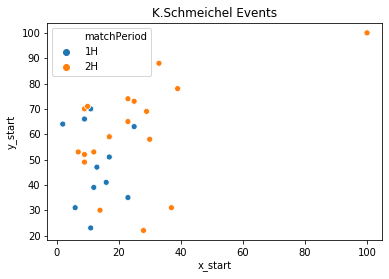

In [29]:
# plot Schmeichel
name = 'K. Schmeichel'
ax = sns.scatterplot(events[(events.shortName == name) & (events['matchId'] == match)]['x_start'],
                events[(events.shortName == name) & (events['matchId'] == match)]['y_start'], 
                hue=events[(events.shortName == name) & (events['matchId'] == match)]['matchPeriod']
               )
ax.legend(loc='best')
plt.title('K.Schmeichel Events');

K. Schmeichel is in his half and near his goal majority of the game time. The point on the far upper right corner is probably a corner where he touched the ball in the dying minutes in the 2nd half of the match. Let's verify that by listing all the events of K. Schmeichel in the given match and analyze them according to the game minutes. 

Also, I sort the dataframe to make sure events will display in chornological order per match.

In [30]:
# sort
events.sort_values(by=['league', 'gameweek', 'matchId', 'matchPeriod', 'eventSec'], inplace=True)

In [31]:
# sanity check
print(events[['eventSec', 'matchPeriod']].head())
print(events[['eventSec', 'matchPeriod']].tail())

   eventSec matchPeriod
0     2.759          1H
1     4.947          1H
2     6.542          1H
3     8.143          1H
4    10.302          1H
         eventSec matchPeriod
1271804  2939.077          2H
1271805  2940.516          2H
1271806  2942.099          2H
1271807  2943.089          2H
1271808  2943.669          2H


In [32]:
# filter and observe
events[(events.shortName == name) & \
       (events['matchId'] == match) &\
       (events['matchPeriod'] == '2H')]\
[['eventName', 'matchPeriod', 'eventMin', 'x_start', 'y_start']].tail()

,eventName,matchPeriod,eventMin,x_start,y_start
1723,Pass,2H,47.122,39,78
1738,Pass,2H,47.706,23,65
1747,Free Kick,2H,48.255,29,69
1763,Pass,2H,49.875,7,53
1767,Free Kick,2H,50.111,100,100


As I suspected! He went up the field in 2nd half very end of the game and took the corner shot. 

To be exact, this particular match was between Arsenal and Leicester City in August of 2017. On the minute of this event, Arsenal was leading the match 4-3. It is expected from the goalkeeper to run up the field and support the attack for a goal to tie the game in the dying minutes. There isn't anything loose to leave the goal open at that moment.

As a result, I verified that the attacks in this dataset are from left to right at all times. We do not need to adjust the coordinates.

In [33]:
# final check before visualizations
events.head()

,id,matchId,gameweek,month,hour,teamHome,teamId,teamName,league,playerId,shortName,role,age,height,weight,foot,eventName,subEventName,matchPeriod,eventSec,x_start,y_start,x_end,y_end,leagueNum,footNum,matchPeriodNum,roleNum,eventMin,eventMinRounded
0,177959171,2499719,1,8,18,Arsenal,1609,Arsenal,england,25413,A. Lacazette,FWD,26.599,175.0,73.0,right,Pass,Simple pass,1H,2.759,49,49,31,78,1,1,1,3,0.046,1
1,177959172,2499719,1,8,18,Arsenal,1609,Arsenal,england,370224,R. Holding,DEF,22.284,189.0,75.0,right,Pass,High pass,1H,4.947,31,78,51,75,1,1,1,1,0.082,1
2,177959173,2499719,1,8,18,Arsenal,1609,Arsenal,england,3319,M. \u00d6zil,MID,29.213,180.0,76.0,left,Pass,Head pass,1H,6.542,51,75,35,71,1,2,1,2,0.109,1
3,177959174,2499719,1,8,18,Arsenal,1609,Arsenal,england,120339,Mohamed Elneny,MID,25.476,180.0,70.0,right,Pass,Head pass,1H,8.143,35,71,41,95,1,1,1,2,0.136,1
4,177959175,2499719,1,8,18,Arsenal,1609,Arsenal,england,167145,Beller\u00edn,DEF,22.790,178.0,74.0,right,Pass,Simple pass,1H,10.302,41,95,72,88,1,1,1,1,0.172,1


### Sanity Checks

In [34]:
events.describe()

,id,matchId,gameweek,month,hour,teamId,playerId,age,height,weight,eventSec,x_start,y_start,x_end,y_end,leagueNum,footNum,matchPeriodNum,roleNum,eventMin,eventMinRounded
count,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06,2.845e+06
mean,2.177e+08,2.533e+06,1.921e+01,6.553e+00,1.595e+01,2.603e+03,9.087e+04,2.681e+01,1.820e+02,7.620e+01,1.392e+03,4.887e+01,4.998e+01,5.200e+01,4.969e+01,2.958e+00,1.260e+00,1.497e+00,1.877e+00,2.320e+01,2.370e+01
std,2.126e+07,3.313e+04,1.077e+01,3.882e+00,2.572e+00,2.219e+03,1.185e+05,3.920e+00,6.974e+00,7.145e+00,8.343e+02,2.464e+01,3.032e+01,2.509e+01,3.071e+01,1.425e+00,4.416e-01,5.000e-01,8.659e-01,1.391e+01,1.390e+01
min,1.761e+08,2.500e+06,1.000e+00,1.000e+00,1.000e+01,6.740e+02,3.300e+01,1.603e+01,0.000e+00,0.000e+00,0.000e+00,-1.000e+00,0.000e+00,0.000e+00,0.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,0.000e+00,0.000e+00
25%,2.006e+08,2.501e+06,1.000e+01,3.000e+00,1.400e+01,1.612e+03,9.414e+03,2.383e+01,1.780e+02,7.200e+01,6.627e+02,3.000e+01,2.300e+01,3.300e+01,2.300e+01,2.000e+00,1.000e+00,1.000e+00,1.000e+00,1.104e+01,1.200e+01
50%,2.187e+08,2.517e+06,1.900e+01,5.000e+00,1.600e+01,2.454e+03,2.560e+04,2.658e+01,1.820e+02,7.600e+01,1.377e+03,4.700e+01,5.000e+01,5.400e+01,5.000e+01,3.000e+00,1.000e+00,1.000e+00,2.000e+00,2.295e+01,2.300e+01
75%,2.338e+08,2.566e+06,2.800e+01,1.000e+01,1.800e+01,3.197e+03,1.372e+05,2.951e+01,1.860e+02,8.100e+01,2.111e+03,6.800e+01,7.700e+01,7.100e+01,7.700e+01,4.000e+00,2.000e+00,2.000e+00,2.000e+00,3.518e+01,3.600e+01
max,2.562e+08,2.576e+06,3.800e+01,1.200e+01,2.000e+01,1.983e+04,5.686e+05,4.100e+01,2.030e+02,1.010e+02,3.537e+03,1.000e+02,1.010e+02,1.000e+02,1.010e+02,5.000e+00,3.000e+00,2.000e+00,4.000e+00,5.896e+01,5.900e+01


In [35]:
events.shape

(2845357, 30)

- All the minimums and maximums look fine, except `height` and `weight`. They have minimum values of 0. I can interact them and get a physical score value for each player.
- The (x,y) coordinate values are in the defined plane with limits of 0 and 100.
- All the means and standard deviation values look normal.
- All the counts match
- The all good!

An average soccer player in Europe is between 175 cm and 185 cm tall. And he weights between 65 kg and 75 kg. Let's create 9 categories around the average zone and assign them to numbers. 

In [36]:
events.loc[(events.height < 175) & (events.weight < 65), "phyScore"] = 1
events.loc[(events.height < 175) & (events.weight >= 65) & (events.weight <= 75), "phyScore"] = 2
events.loc[(events.height < 175) & (events.weight > 75), "phyScore"] = 3
events.loc[(events.height >= 175) & (events.height <= 185) & (events.weight < 65), "phyScore"] = 4
events.loc[(events.height >= 175) & (events.height <= 185) & (events.weight >= 65) & (events.weight <= 75), "phyScore"] = 5
events.loc[(events.height >= 175) & (events.height <= 185) & (events.weight > 75), "phyScore"] = 6
events.loc[(events.height > 185) & (events.weight < 65), "phyScore"] = 7
events.loc[(events.height > 185) & (events.weight >= 65) & (events.weight <= 75), "phyScore"] = 8
events.loc[(events.height > 185) & (events.weight > 75), "phyScore"] = 9

In [37]:
events.phyScore.value_counts()

5.0    880539
9.0    791311
6.0    716060
2.0    254797
1.0     92858
8.0     85083
4.0     16494
3.0      7419
7.0       796
Name: phyScore, dtype: int64

This is not clear to uninitiated eyes:). Let me clarify a bit more:  **hight class-weight class**

In [38]:
phyScore_dict = {1: "short-thin", 2: "short-normal", 3: "short-stocky",
                4: "normal-thin", 5: "normal-normal", 6: "normal-stocky",
                7: "tall-thin", 8: "tall-normal", 9: "tall-stocky"}
events['phyClass'] = events['phyScore'].map(phyScore_dict)

In [39]:
events.head(2)

,id,matchId,gameweek,month,hour,teamHome,teamId,teamName,league,playerId,shortName,role,age,height,weight,foot,eventName,subEventName,matchPeriod,eventSec,x_start,y_start,x_end,y_end,leagueNum,footNum,matchPeriodNum,roleNum,eventMin,eventMinRounded,phyScore,phyClass
0,177959171,2499719,1,8,18,Arsenal,1609,Arsenal,england,25413,A. Lacazette,FWD,26.599,175.0,73.0,right,Pass,Simple pass,1H,2.759,49,49,31,78,1,1,1,3,0.046,1,5.0,normal-normal
1,177959172,2499719,1,8,18,Arsenal,1609,Arsenal,england,370224,R. Holding,DEF,22.284,189.0,75.0,right,Pass,High pass,1H,4.947,31,78,51,75,1,1,1,1,0.082,1,8.0,tall-normal


Let's save the data in csv format.

In [40]:
# version 1 (Goalkeepers included)
events.to_csv("../../csv_files/AI_in_Soccer/02-eventsAll_wGKP.csv")

### Multiclass Target Construction

This part is for the 2nd wing, event prediction. To expand on that, let's check the current events.

In [41]:
list(events.eventName.unique())

['Pass',
 'Duel',
 'Foul',
 'Shot',
 'Save attempt',
 'Others on the ball',
 'Free Kick',
 'Goalkeeper leaving line',
 'Offside',
 'Interruption']

I would like to clarify something before diving into the labeling. Soccer is a dynamic game. It is just like syncronizing a bunch of continuous activities. Given that, one of the most effective features are the (x,y) coordinates. Therefore, the data needs movement to reflect reliable information. And goalkeepers are not that active in terms of vertical and horizontal movement on the pitch. Their play is completely different from an open field player like a forward or midfielder, hence their misalignment with the purpose of the model. Consequently, I want to exclude them from this project's core.

In [42]:
# define a new dataframe without the goalkeeper
events = events[events.role != 'GKP']

One important detail to watch out is the events strictly owned by the goalkeeper position. What I mean by that is as follows: In the game of football, if the player substitution limit is reached (3 subs) and the goalkkeper gets a red card punishment and forced to leave the pitch, a player have to replace him, act as a goal keeper, and guard the goal as a goalkeeper. This situation does not change his permanent role, just gives him temporary role in the current match. And, it has potential to add mode goalkeeper related sub-events such as "Save Attempt" or "Hand pass". To avoid such misconception, let's exclude any present goalkeeper event.

In [43]:
# make the list of strictly Goalkeeper related events.
GK_subEvents = ['Goal kick', 'Hand pass', 'Reflexes', 'Save attempt', 'Goalkeeper leaving line']
events = events[~events.subEventName.isin(GK_subEvents)]

In [44]:
events.shape

(2702465, 32)

Next step is to define the targets.

Let's check the current events again and go from there.

In [45]:
list(events.eventName.unique())

['Pass',
 'Duel',
 'Foul',
 'Shot',
 'Others on the ball',
 'Free Kick',
 'Offside',
 'Interruption']

I need more clarification. I decide to list the events with the related subEvents and assist the decision making.

In [46]:
# temp event table
_ = (events.groupby(['eventName', 'subEventName'])
     .size()
     .reset_index()
     .sort_values(by=['eventName', 'subEventName']))
_

,eventName,subEventName,0
0,Duel,Air duel,144295
1,Duel,Ground attacking duel,242124
2,Duel,Ground defending duel,234676
3,Duel,Ground loose ball duel,125032
4,Foul,Foul,43894
5,Foul,Hand foul,1919
6,Foul,Late card foul,300
7,Foul,Out of game foul,450
8,Foul,Protest,523
9,Foul,Simulation,108


After looking at the table, here is how I justify the new events as my targets:
 - **short_pass**: Any kind of ground pass or simple pass or through pass.
 - **long_pass**: Air passes that goes more than 20 yards such as high pass or launch.
 - **shot**: As is including ball movement leads to potential goal scored such as free kick shots and penalty shots.
 - **control**: Events on the ball with the involvement of one or more players such as duels, accelarations, touches.
 - **game_break**: Events resulting with a break in the game such as offside, foul, and whistle.

In [47]:
event_dict = {
    'Simple pass': 'short_pass',
    'High pass': 'long_pass',
    'Ground defending duel': 'control',
    'Ground attacking duel': 'control',
    'Throw in': 'short_pass',
    'Head pass': 'short_pass',
    'Shot': 'shot',
    'Touch': 'control',
    'Clearance': 'control',
    'Ground loose ball duel': 'control',
    'Launch': 'long_pass',
    'Air duel': 'control',
    'Corner': 'long_pass',
    'Smart pass': 'short_pass',
    'Foul': 'game_break',
    'Free Kick': 'long_pass',
    'Cross': 'long_pass',
    'Hand foul': 'game_break',
    'Acceleration': 'control',
    'Late card foul': 'game_break',
    'Ball out of the field': 'game_break',
    'Free kick cross': 'long_pass',
    'Violent Foul': 'game_break',
    'Penalty': 'shot',
    'Free kick shot': 'shot',
    'Protest': 'game_break',
    'Time lost foul': 'game_break',
    'Out of game foul': 'game_break',
    'Simulation': 'game_break',
    'Whistle': 'game_break',
    'Offside': 'game_break'}

In [49]:
# create the target and map the events
events['event'] = events['subEventName'].map(event_dict)

# sanity checks
print(events.event.value_counts())
print(events.event.shape[0] == events.shape[0])
print(events.event.isna().sum())

short_pass    1378645
control        982583
long_pass      242999
game_break      55208
shot            43030
Name: event, dtype: int64
True
0


The count dictributions seem reasonable. Let's some more insights via pictures!

### Visualizations

First I wish to check the distribution of the new events I created for labeling.

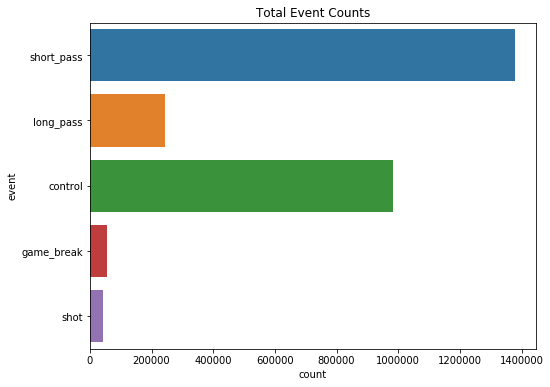

In [50]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(y="event", data=events)
plt.title("Total Event Counts");

In [51]:
print(f"Short pass percentage:{(events[events.event == 'short_pass'].shape[0] / events.shape[0]) * 100: .2f}%")
print(f"Control percentage:{(events[events.event == 'control'].shape[0] / events.shape[0]) * 100: .2f}%")
print(f"Average number of short passes in a match:{events[events.event == 'short_pass'].shape[0] / events.matchId.nunique(): .0f}.")

Short pass percentage: 51.01%
Control percentage: 36.36%
Average number of short passes in a match: 755.


The event short_pass covers 51% of the entire event set. That is normal. In a game of soccer, it is ok to see average of 755 short passes.

Control takes a little over quarter of the event total. Again, soccer is a physical game and a good portion of the competition takes place between players and ball of opposite sides.

Small amount shots reminds me about how hard it is to find an opening and take shot in a professional soccer game. Also, there is a small amount of game breaks, hence the continuously dynamic nature of soccer.

What about the distribution among the different leagues?

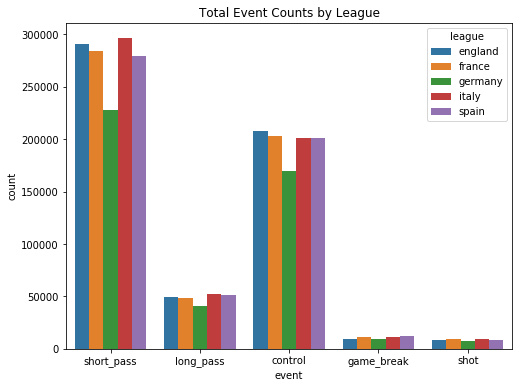

In [52]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="event", data=events, hue='league')
plt.title("Total Event Counts by League");

All the distributions look ok except Germany. I am suspecting the number of the game weeks. Let's to make sure...

In [53]:
for league in list(events['league'].unique()):
    
    print("The football league of", league, 
          f"is {events[events['league'] == league]['gameweek'].nunique()} weeks long.")


The football league of england is 38 weeks long.
The football league of france is 38 weeks long.
The football league of germany is 34 weeks long.
The football league of italy is 38 weeks long.
The football league of spain is 38 weeks long.


Yep!

Wouldn't it be great to see the distribution of these events on an actual soccer field? First, I need to scale the coordinates to offical (approximate) measurements of the soccer field, 120 yards by 80 yards. Then I can fit. 

For the drawing, please see **Pitch 1** in **Storage** section.

In [56]:
# scale x's
events['x_start_scaled'] = events['x_start'].map(lambda x: x * 120 / 100)
events['x_end_scaled'] = events['x_end'].map(lambda x: x * 120 / 100)

# scale y's'
events['y_start_scaled'] = events['y_start'].map(lambda x: x * 80 / 100)
events['y_end_scaled'] = events['y_end'].map(lambda x: x * 80 / 100)

In [57]:
events.head(2)

,id,matchId,gameweek,month,hour,teamHome,teamId,teamName,league,playerId,shortName,role,age,height,weight,foot,eventName,subEventName,matchPeriod,eventSec,x_start,y_start,x_end,y_end,leagueNum,footNum,matchPeriodNum,roleNum,eventMin,eventMinRounded,phyScore,phyClass,event,x_start_scaled,x_end_scaled,y_start_scaled,y_end_scaled
0,177959171,2499719,1,8,18,Arsenal,1609,Arsenal,england,25413,A. Lacazette,FWD,26.599,175.0,73.0,right,Pass,Simple pass,1H,2.759,49,49,31,78,1,1,1,3,0.046,1,5.0,normal-normal,short_pass,58.8,37.2,39.2,62.4
1,177959172,2499719,1,8,18,Arsenal,1609,Arsenal,england,370224,R. Holding,DEF,22.284,189.0,75.0,right,Pass,High pass,1H,4.947,31,78,51,75,1,1,1,1,0.082,1,8.0,tall-normal,long_pass,37.2,61.2,62.4,60.0


In [58]:
# create a list of events
event_list = list(events.event.unique())
event_list

['short_pass', 'long_pass', 'control', 'game_break', 'shot']

Since the dataset has many teams and many events, the pictures will be very crowded and possibly unclear due to high frequency of shades. To avoid that, I will pick one team (my favorite - bias!!) and cover the matches between weeks 1 & 5 and display the distributions.

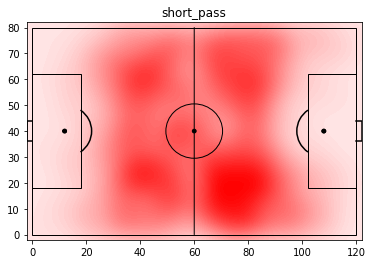

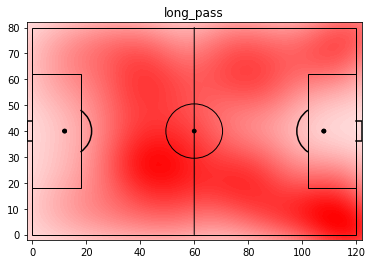

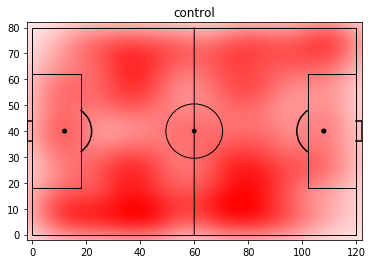

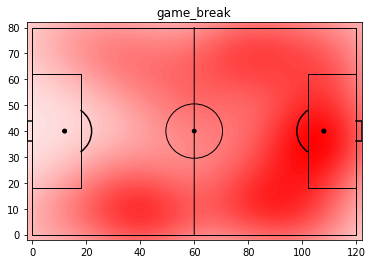

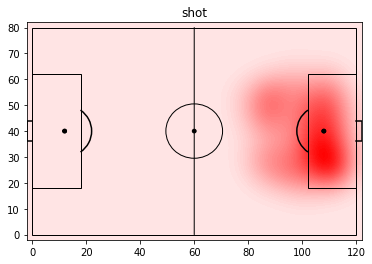

In [92]:
#loop the event_list and visualize each event

# must ru the football_pitch_1 function in "Storage"
for event in event_list:    
    
    # setup dataframe
    _ = events[(events['event'] == event) & \
               (events['teamName'] == 'Arsenal') & \
               (events['gameweek'] < 6)]

    # plot
    fig, ax = plt.subplots()
    football_pitch_1(ax)
    plt.ylim(-2, 82)   # extend the pitch beyond goal lines
    plt.xlim(-2, 122)  # extend the pitch beyond touch lines
    plt.axis('on')

    fig.set_size_inches(6, 4)

    x_coord = [i for i in _["x_start_scaled"]] + [-10, 130]    # fake data point to extend the heat 
                                                               # distribution in case of a small number of events

    y_coord = [i for i in _["y_start_scaled"]] + [-10, 90]     # fake data point to extend the heat 
                                                               # distribution in case of a small number of events

    #shades: give us the heat map we desire
    # n_levels: intensity of the shade
    sns.kdeplot(x_coord, y_coord, shade = "True", color = "r", n_levels = 60)
    plt.title(event)
    plt.show()

Considering the attack direction is from left to right, these all make sense:
 - Short passes are concetrated in the middle half of the pitch. Midfielders and central defenders are the ultimate short passers.
 - Long passes are high in the defending half and on the sides of the offending half of the pitch. Defenders and midfielders pull a long through one to the fast running attackers. Also, the crosses from the attack areas close to side-lines are heavily shaded. Sounds very Arsenal like!
 - Control happens all over the place, hence control is the one on ones and single plays are foundation of soccer. Also, I see some movement on the sides a bit due to the dribbling and accelarations performed by attackers.
 - Game breaks happend mostly on the offensive halves and sides. A lot of the fouls are safer to commit on the areas close to sidelines than central area (more defensively dangerous). Also, the fast wingers are being caught offside. iN Arsenal case, right back defender Bellerin has a ton in hiz zone (right bottom of defending half) due to him putting his mind more into offense! He needs to focus on defense a bit more.
 - Shots speak for themselves, not much to say there. Best area to take them are in front of the opponents goal, in the 18 yard box. The two baloons outside of the box (20-40 yards) are the long direct shots by central midfielders or strikers, or curved shots by the opposite-foot players like Pepe (right midfielder with left foot).
 
All seem normal to me. The labels are ready!

Due to the limited time I have for this project, I want to save some processing time. I can take a mini dataset. The perfect candidate is English league. But, I need to compare the distribution of its events to the total to make sure I am working and training my event predictor on a similar distribution. If that works, it will be a major time saver.

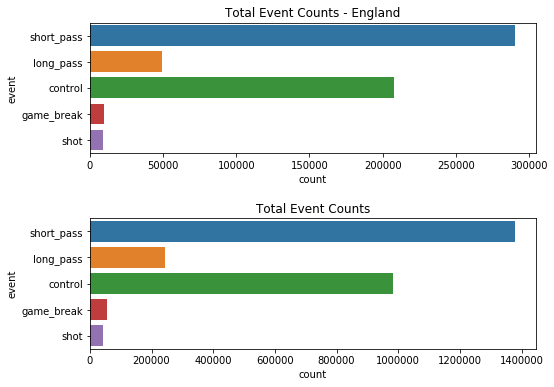

In [71]:
# filter English league
events_eng = events[events['league'] == 'england']

# figure size and spacing
plt.figure(figsize=(8, 6))
plt.subplots_adjust(hspace=.5)

# england event chart
plt.subplot(2,1,1)
ax = sns.countplot(y="event", data=events_eng)
plt.title("Total Event Counts - England");

# total event chart for comparison
plt.subplot(2,1,2)
ax = sns.countplot(y="event", data=events)
plt.title("Total Event Counts");

Let's not worry about the scales, just focus on the bar lenghts and ratios to total in each graph. All I want to see is the similarity of the distributions. And they look similar! 

Excellent! This relevance will help in training the event predictor in 2nd wing by saving a lot of precious time. Because I now can use the mini-dataset (*events_eng*) to test the hyper-parameters and perform feature enginering in a shorter processing time. Once I am happy, I can scale it with the bigger dataset (*events*)

By the way, less gamebreaks in English league is totally normal given the nature of Premier League. If you don't trust me on that, just watch a Premier League match and then a Italian league match!

Here are comple more pictures.

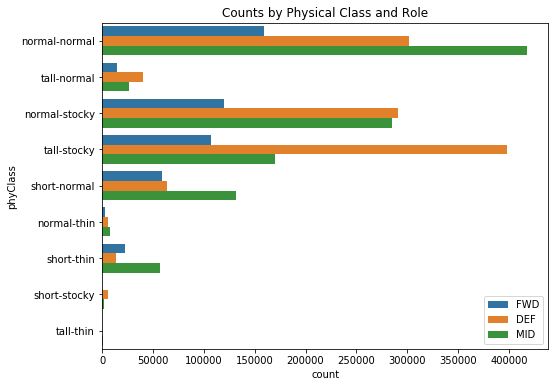

In [73]:
# just curios about the distribution of phySpec and role
plt.figure(figsize=(8, 6))
ax = sns.countplot(y="phyClass", data=events, hue='role')
plt.title("Counts by Physical Class and Role")
plt.legend(loc='lower right');

Interesting. It seems like defenders are getting faster or the tactical field coverage is improving. Why did I just say that? Because, look at the most popular size of the defenders, and I mean these are the players who have to deal with fast and agil strikers and wingers. There is a possibility that the training has improved in a way.

In my basketball days, we were training to dribble with large gaps to shorten the travel time between two points. To illustrate, I was able run from one end to other end (horizontal) of the field with only 3 to 4 dribbles. I sense a similar training method for defenders in soccer, hence bigger steps and shorter travel times between coordinates. That makes sense! 

If you are confused by this, no worries, this is just an observation. It may or may not impact my models (at least not in this version).

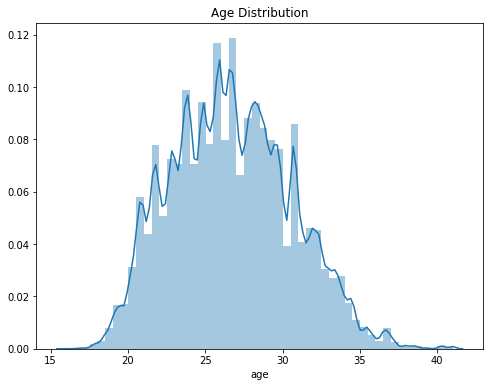

In [454]:
# what about age distribution
plt.figure(figsize=(8, 6))
ax = sns.distplot(events["age"])
plt.title("Age Distribution");

A spike and small hill after 30! 

Nowadays, 30+ is not old anymore, given the improved mortality (from Actuarial days) and technology in training (domain knowledge). 

I want to check the event distribution by role. First , check the count of roles. If it is unbalances, it needs to be adjusted for better knowledge.

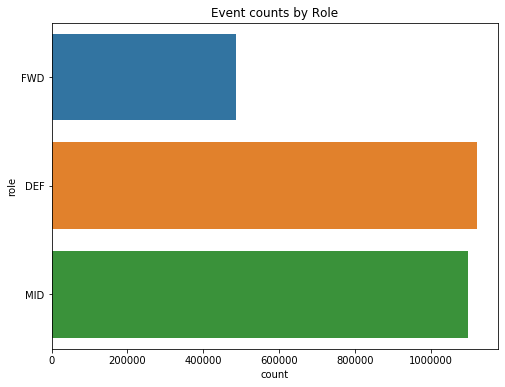

In [78]:
# just curios about the distribution of phySpec and role
plt.figure(figsize=(8, 6))
ax = sns.countplot(y="role", data=events)
plt.title("Event counts by Role");

The FWD count seems about 50% of the others. I can fix that witha simple dummy df to serve the purpose of comparing them under equal circumstances. Let's double number of FWD's.

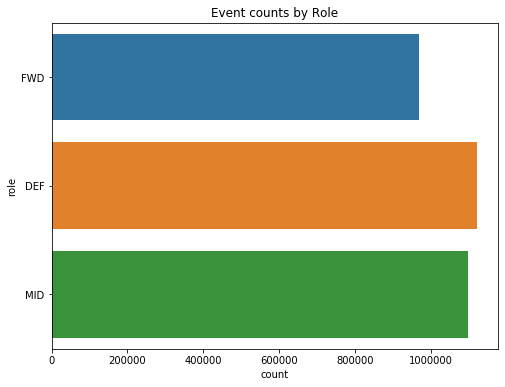

In [83]:
_ = events[['role', 'event']]
_FWD = _[_['role'] == "FWD"]
_ = pd.concat([_, _FWD], ignore_index=True)
_.shape

plt.figure(figsize=(8, 6))
ax = sns.countplot(y="role", data=_)
plt.title("Event counts by Role");

Now let see the updated distribution.

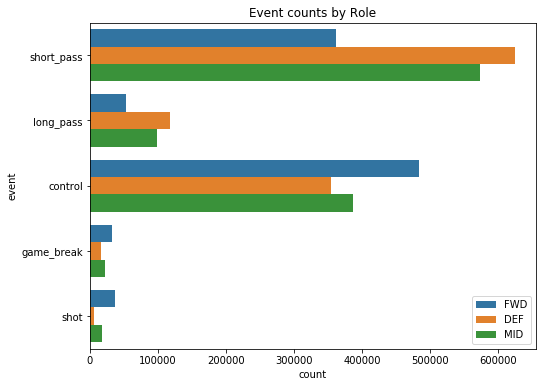

In [84]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(y="event", data=_, hue='role')
plt.title("Event counts by Role")
plt.legend(loc='lower right');

Aha! More shots, more controls, and more game breaks for FWD players. Very very very true! They are the most dangerous ones. They go through a lot of one-on-ones. Thye take many shots and they receive the hardest tackles ending with fouls and commit the most offsides, hence game breaks. 

Between the defenders and midfielders: Defenders lead the passes which can be ok due to DEF being slightly more in numbers in this dataset. Also, MID makes it up with control and shot counts. Which seems correct. 

Actually, this analysis helped me a lot. I decide to use a midfielder as my test subject in the 1st wing (player location predictor). Good news about this decision is they are involved with a lot of events given their nature and locations in the game. The abd news is that they are everywhere! I mean, they help defending and atatcking, they sprint front and back, they move box to box. All these lead to a bigger challange for the 1st wing. I liked it! Please break my model, so I can make it better:).

In [455]:
# a final look at the dataset
events.head()

,id,matchId,gameweek,month,hour,teamHome,teamId,teamName,league,playerId,shortName,role,age,height,weight,foot,eventName,subEventName,matchPeriod,eventSec,x_start,y_start,x_end,y_end,leagueNum,footNum,matchPeriodNum,roleNum,eventMin,eventMinRounded,phyScore,phyClass,event,x_start_scaled,x_end_scaled,y_start_scaled,y_end_scaled
0,177959171,2499719,1,8,18,Arsenal,1609,Arsenal,england,25413,A. Lacazette,FWD,26.599,175.0,73.0,right,Pass,Simple pass,1H,2.759,49,49,31,78,1,1,1,3,0.046,1,5.0,normal-normal,short_pass,58.8,37.2,39.2,62.4
1,177959172,2499719,1,8,18,Arsenal,1609,Arsenal,england,370224,R. Holding,DEF,22.284,189.0,75.0,right,Pass,High pass,1H,4.947,31,78,51,75,1,1,1,1,0.082,1,8.0,tall-normal,long_pass,37.2,61.2,62.4,60.0
2,177959173,2499719,1,8,18,Arsenal,1609,Arsenal,england,3319,M. \u00d6zil,MID,29.213,180.0,76.0,left,Pass,Head pass,1H,6.542,51,75,35,71,1,2,1,2,0.109,1,6.0,normal-stocky,short_pass,61.2,42.0,60.0,56.8
3,177959174,2499719,1,8,18,Arsenal,1609,Arsenal,england,120339,Mohamed Elneny,MID,25.476,180.0,70.0,right,Pass,Head pass,1H,8.143,35,71,41,95,1,1,1,2,0.136,1,5.0,normal-normal,short_pass,42.0,49.2,56.8,76.0
4,177959175,2499719,1,8,18,Arsenal,1609,Arsenal,england,167145,Beller\u00edn,DEF,22.790,178.0,74.0,right,Pass,Simple pass,1H,10.302,41,95,72,88,1,1,1,1,0.172,1,5.0,normal-normal,short_pass,49.2,86.4,76.0,70.4


In [85]:
# delete the dummy df's
del _
del _FWD

In [86]:
# check the directory before saving
!pwd

/Users/atahankocak/ds/Projects/A.I-in-Soccer/notebook


In [87]:
# save the events data for modeling. 2 versions
events.to_csv("../../csv_files/AI_in_Soccer/02-eventsAll.csv")
events_eng.to_csv("../../csv_files/AI_in_Soccer/02-eventsEng.csv")

### Storage

#### Pitch_1

In [66]:
# setup dataframes for testing
df_team_1 = events[(events['matchId'] == 2499719) & 
               (events['teamName'] == 'Arsenal') & 
               (events['matchPeriod'] == '1H') &
               (events['eventName'] == 'Pass')]

df_team_2 = events[(events['matchId'] == 2499719) & 
               (events['teamName'] == 'Leicester City') & 
               (events['matchPeriod'] == '2H') &
               (events['eventName'] == 'Pass')] 

In [90]:
# white pitch - good for density heat maps
def football_pitch_1(ax):

    #Pitch Outline
    pitch = plt.Rectangle([0,0], width = 120, height = 80, fill = False)
    
    # midline
    midline = matplotlib.patches.ConnectionPatch([60,0], [60,80], "data", "data")
    
    #Left, Right Penalty Area
    leftPenSpot = plt.Rectangle([0,30], width = 6, height = 20, fill = False)
    rightPenSpot = plt.Rectangle([114,30], width = 6, height = 20, fill = False)
    
    # left goal
    ly4 = [36,36,44,44]
    lx4 = [120,122,122,120]
    plt.plot(lx4,ly4,color='black', zorder=5, lw=1.5)
    
    # right goal
    ly5 = [36,36,44,44]
    lx5 = [0,-2,-2,0]
    plt.plot(lx5,ly5,color='black', zorder=5, lw=1.5)
    
    #Left, Right 18-yard Box
    leftYard = plt.Rectangle([0,18], width = 18, height = 44, fill = False)
    rightYard = plt.Rectangle([102,18], width = 18, height = 44, fill = False)
    
    # penalty spots 
    leftPenSpot = plt.Circle((12,40),0.71,color="black")
    rightPenSpot = plt.Circle((108,40),0.71,color="black")
    
    # arcs around penalty spots
    rightArc = matplotlib.patches.Arc((108,40), height=20, width=20, angle=0, theta1=126, theta2=234,
                                     color='black', lw=1.5, alpha=1)
    leftArc = matplotlib.patches.Arc((12,40), height=20, width=20, angle=0, theta1=306, theta2=54,
                                     color='black', lw=1.5, alpha=1)
    
    # middle circle and spot
    centreCircle = plt.Circle((60,40),10.5,color="black", fill = False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
      
    element = [pitch, leftPenSpot, rightPenSpot, midline, leftYard, rightYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    for i in element:
        ax.add_patch(i)

#### Pitch 1 - Test

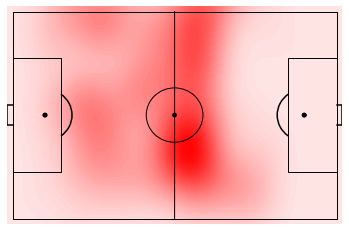

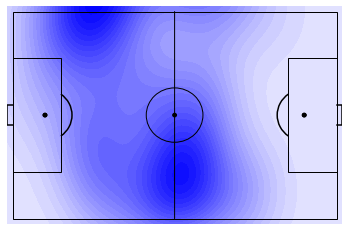

In [91]:
fig, ax = plt.subplots()
football_pitch_1(ax)
plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.axis('off')

fig.set_size_inches(6, 4)

x_coord = [i for i in df_team_1["x_start"]] + [-10, 130]
y_coord = [i for i in df_team_1["y_start"]] + [-10, 90]

#shades: give us the heat map we desire
# n_levels: draw more lines, the larger n, the more blurry it looks
sns.kdeplot(x_coord, y_coord, shade = "True", color = "r", n_levels = 60)
plt.show()


fig, ax = plt.subplots()
football_pitch_2(ax)
plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.axis('off')

fig.set_size_inches(6, 4)

x_coord = [i for i in df_team_2["x_start"]] + [-10, 130]
y_coord = [i for i in df_team_2["y_start"]] + [-10, 90]

#shades: give us the heat map we desire
# n_levels: draw more lines, the larger n, the more blurry it looks
sns.kdeplot(x_coord, y_coord, shade = True, color = "b", n_levels = 30, gridsize=120)
plt.show()